In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.neighbors import kneighbors_graph
from sklearn.feature_selection import f_classif, SelectKBest, SequentialFeatureSelector
from sklearn.metrics import confusion_matrix, silhouette_score, homogeneity_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [3]:
data.shape

(12146, 30703)

In [5]:
data = data.drop(data.columns[[0,2,3,-1]], axis=1)

In [9]:
klase = data.iloc[:, 0].apply(lambda x: re.sub(r'_\d+$', '', x))

In [10]:
klase.to_csv('klase.csv', index=False)

In [11]:
oznake_klasa = {
"BC": 0,    
"DC": 1,   
"MC": 2,
"NK": 3, 
"TC": 4,
}

oznake_klasa_grupisane = {
"BC": 0,    
"DC": 1,   
"MC": 2,
"NK": 3, 
"TC": 4,
}

klase = klase.replace(oznake_klasa)

In [12]:
set(klase)

{0, 1, 2, 3, 4}

In [13]:
klase.shape

(12146,)

In [15]:
X = data

In [17]:
X['Cell_type'] = X['Cell_type'].apply(lambda x: 0 if x == 'BC' else x)
X['Cell_type'] = X['Cell_type'].apply(lambda x: 1 if x == 'DC' else x)
X['Cell_type'] = X['Cell_type'].apply(lambda x: 2 if x == 'MC' else x)
X['Cell_type'] = X['Cell_type'].apply(lambda x: 3 if x == 'NK' else x)
X['Cell_type'] = X['Cell_type'].apply(lambda x: 4 if x == 'TC' else x)

In [18]:
variances = X.var()
print(variances)
print(f'Mean: {variances.mean()}')
print(f'Median: {variances.median()}')
print(f'Min: {variances.min()}')
print(f'Max: {variances.max()}')

Cell_type          2.226705
hg38_ZFP41         0.002137
hg38_ASF1A         0.074015
hg38_TMEM39A       0.035085
hg38_OR2M7         0.000000
                     ...   
hg38_TPH2          0.000905
hg38_LINC00626     0.000000
hg38_LRRC29        0.003039
hg38_AC073333.8    0.000082
hg38_ZFP36         0.669135
Length: 30699, dtype: float64
Mean: 0.038123135479611533
Median: 0.0016440565950823249
Min: 0.0
Max: 2.587398569226056


In [20]:
vt = VarianceThreshold(threshold=0.05)
X_vt_1 = vt.fit_transform(X)

In [21]:
X_vt_1_df = pd.DataFrame(data=X_vt_1)
X_vt_1_df.to_csv('X_vt_1.csv', index=False)

In [22]:
X_vt_1.T.var().min()

0.3645534092874025

In [44]:
X_vt_1.shape

(12146, 5777)

In [23]:
pca = PCA()
X_vt_1_pca = pca.fit_transform(X_vt_1)

In [24]:
pca.explained_variance_ratio_[:50].sum()

0.18100758504229464

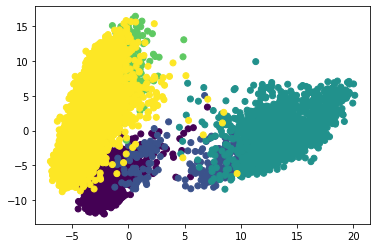

In [25]:
plt.scatter(X_vt_1_pca[:, 0], X_vt_1_pca[:, 1], c=klase.values)

In [26]:
# Testirati drugačije načine konstrukcije grafa
X_vt_1_graph = kneighbors_graph(
    X_vt_1, 
    n_neighbors=150, 
    mode='distance', 
    metric='cosine',
    n_jobs=-1
)

X_vt_1_graph_map = kneighbors_graph(
    X_vt_1, 
    n_neighbors=150, 
    mode='connectivity', 
    metric='cosine',
    n_jobs=-1
)

In [27]:
X_vt_1_graph_arr = X_vt_1_graph.toarray()
X_vt_1_graph_map_arr = X_vt_1_graph_map.toarray()
X_vt_1_graph_full = X_vt_1_graph_arr

X_vt_1_graph_full = 1.0 / (1.0 + X_vt_1_graph_arr)

In [28]:
X_vt_1_graph_full[X_vt_1_graph_map_arr == 0] = 0

In [29]:
sc = SpectralClustering(
    n_clusters=5, 
    affinity='precomputed', 
    n_components=2
)
sc.fit(X_vt_1_graph_full)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


SpectralClustering(affinity='precomputed', n_clusters=5, n_components=2)

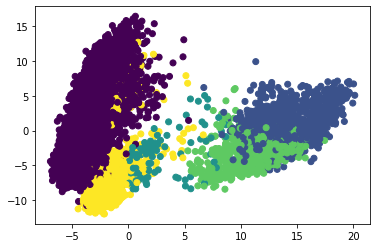

In [30]:
plt.scatter(X_vt_1_pca[:, 0], X_vt_1_pca[:, 1], c=sc.labels_)

In [31]:
silhouette_score(X_vt_1, labels=sc.labels_, metric='cosine')

0.030383148965392345

In [32]:
homogeneity_score(klase.values.ravel(), sc.labels_)

0.7143906426785068

In [36]:
labels = sc.fit_predict(X_vt_1_graph_full)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [38]:
labels.shape

(12146,)

In [42]:
labels

array([3, 3, 3, ..., 1, 1, 1], dtype=int32)

In [43]:
X_vt_1_df

,0,1,2,3,4,5,6,7,8,9,...,5767,5768,5769,5770,5771,5772,5773,5774,5775,5776
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12141,4,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
12142,4,0,0,0,0,1,0,0,1,0,...,0,1,0,0,1,1,0,0,1,2
12143,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,2,0,0,0,0,2
12144,4,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [46]:
pocetne_klase = X_vt_1_df[0]

In [48]:
dodeljene_klase = labels

In [63]:
tabela = pd.DataFrame({'pocetne_klase': pocetne_klase, 'klasteri': dodeljene_klase})

In [64]:
tabela

,pocetne_klase,klasteri
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12141,4,1
12142,4,1
12143,4,1
12144,4,1


In [65]:
tabela.to_csv('tabela.csv', index=False)